In [16]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from scipy.interpolate import splrep, splev
from scipy.stats import  expon, uniform, rv_continuous, ks_2samp, genpareto, zscore, norm
from typing import Callable

Helper functions

In [17]:
def get_ams(time: np.ndarray, value: np.ndarray) -> np.ndarray:
    """Extract annual maximums from timeseries."""
    year = np.floor(time / 365)
    ams = []
    for y in np.unique(year):
        ams.append(value[year == y].max())
    return np.array(ams)

In [18]:
def sst(storm_catalog: list, spatial_sampler: rv_continuous, watershed_function: Callable) -> list:
    """Randomly transpose storms across a domain and evaluate basin discharge."""
    new_locs = spatial_sampler.rvs(size=len(storm_catalog))
    qs = storm_catalog * watershed_function(new_locs)
    return qs

Combine many elements of example #1

In [19]:
def run_simulation(storm_catalog: list, lambda_catalog: float, sst_location_dist, simulated_length: int, epochs: int):
    sst_arrival_dist = expon(scale = 1 / lambda_catalog)

    sst_qs = []

    for e in range(epochs):
        # Simulate storm dates
        interevents = sst_arrival_dist.rvs(int(simulated_length * (lambda_catalog) * 365 * 1.2))
        arrivals = interevents.cumsum()
        arrivals = arrivals[arrivals < (simulated_length * 365)]
        n = len(arrivals)
    
        sampled_storms = np.random.choice(storm_catalog, n)
        sampled_qs = sst(sampled_storms, sst_location_dist, watershed)
        sampled_ams = get_ams(arrivals, sampled_qs)
        sst_qs.append(sampled_ams)
    
    return sst_qs


In [20]:
def watershed(x_pred):
    y = [6000, 7000, 5500, 8000, 4000, 3000, 3500, 2500, 4000, 2000, 1000, 500, 1000]  # Unit discharge
    n = len(y)
    x = np.linspace(0, 100, n)  # watershed spatial component
    tck = splrep(x, y)
    return splev(x_pred, tck, ext=1)

In [21]:
# Hydrologic region
storm_rate = 240  # 24 storms per year
storm_rate /= 365 # storms per day
arrival_dist = expon(scale = 1 / storm_rate)
precipitation_dist = genpareto(c=0.5, loc=1, scale=10)
location_dist = uniform(0, 1000)

In [22]:
# Get long-term flood series
record_length = 1000  # years
np.random.seed(5)

# Get event times
interevents = arrival_dist.rvs(int(record_length * storm_rate * 365 * 1.2))
arrivals = interevents.cumsum()
arrivals = arrivals[arrivals < (record_length * 365)]
n = len(arrivals)

# Get event characteristics
p = precipitation_dist.rvs(size=n)
l = location_dist.rvs(size=n)

# Get long-term flood series.
qs = p * watershed(l)
ams = get_ams(arrivals, qs)

# Prep for plotting
q_sort = np.sort(ams)[::-1]
aep = np.array([(i + 1) / (len(ams) + 1) for i in range(len(ams))])
z_lt = norm.ppf(1 - aep)

In [23]:
# Get limited observation series
observed_record_length = 30  # years
p_obs = p[arrivals < (observed_record_length * 365)]
t_obs = arrivals[arrivals < (observed_record_length * 365)]
lambda_obs = len(t_obs) / observed_record_length  # events per year

### Example 3: A better way to sample

In example 2 we saw how you need a very high arrival rate to characterize the lower end of the flood frequency curve (frequent events).  This is because with low arrival rates many years will have no events.  Instead of overcompensating with a higher arrival rate, we can do the opposite.  We can decrease arrival rate while also decreasing the spatial sampler area.

Note that we updated the parameterization of `run_simulation` to allow us to modify some values.

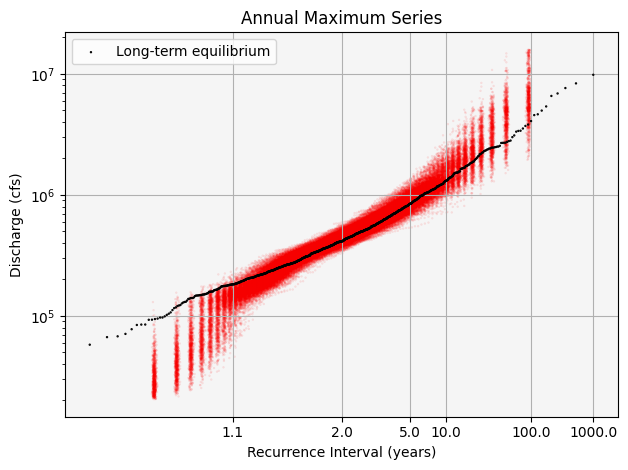

In [25]:
sst_location_dist = uniform(0, 100)  # only allow storms in the watershed.
storm_count = 750  # Just like in example 1
storm_catalog = np.sort(np.array(p_obs))[-storm_count:]
lambda_catalog = storm_count / observed_record_length
lambda_catalog /= 365
lambda_catalog /= 10  # because we decreased the sampling area by a factor of 10, we must decrease the storm frequency by the same factor.
sst_qs = run_simulation(storm_catalog, lambda_catalog, sst_location_dist, 100, 1000)

fig, ax = plt.subplots()

for i in sst_qs:
    tmp_q_sort = np.sort(i)[::-1]
    aep = np.array([(i + 1) / (len(tmp_q_sort) + 1) for i in range(len(tmp_q_sort))])
    z = norm.ppf(1 - aep)
    ax.scatter(z, tmp_q_sort, ec='r', fc='none', s=0.5, alpha=0.1, zorder=1)

ax.scatter(z_lt, q_sort, ec='k', fc='none', s=0.5, label="Long-term equilibrium", zorder=2)

ax.legend()
ris = np.array([1.1, 2, 5, 10, 100, 1000])
aep = 1 / ris
z_ticks = norm.ppf(1 - aep)
ax.set_xticks(z_ticks)
ax.set_xticklabels(ris)
ax.set_xlabel("Recurrence Interval (years)")
ax.set_yscale("log")
ax.set_ylabel("Discharge (cfs)")
ax.set_title("Annual Maximum Series")
ax.set_facecolor("whitesmoke")
plt.grid(True)
plt.tight_layout()

Compared with example 1, we have much better characterization of the lower end of the distribution while running the same number of simulations.